In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [12]:
#Read in data(for data manipulation)
df=pd.read_csv('../input/amazon-fine-food-reviews/Reviews.csv')
print(df.shape)
df= df.head(500)
print(df.shape)


(568454, 10)
(500, 10)


In [13]:
df.head

<bound method NDFrame.head of       Id   ProductId          UserId                      ProfileName  \
0      1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1      2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2      3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3      4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4      5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
..   ...         ...             ...                              ...   
495  496  B000G6RYNE   APGAA43E3WPN7                           Darren   
496  497  B000G6RYNE    ABR7HU5H1KNE                            Keith   
497  498  B000G6RYNE   AJQD2WWJYOYFQ                          bubbles   
498  499  B000G6RYNE  A16YH487W9ZYO0                 Bruce G. Lindsay   
499  500  B000G6RYNE   A83YQC1XOU4CS                         J. Baker   

     HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                    

Quick EDA

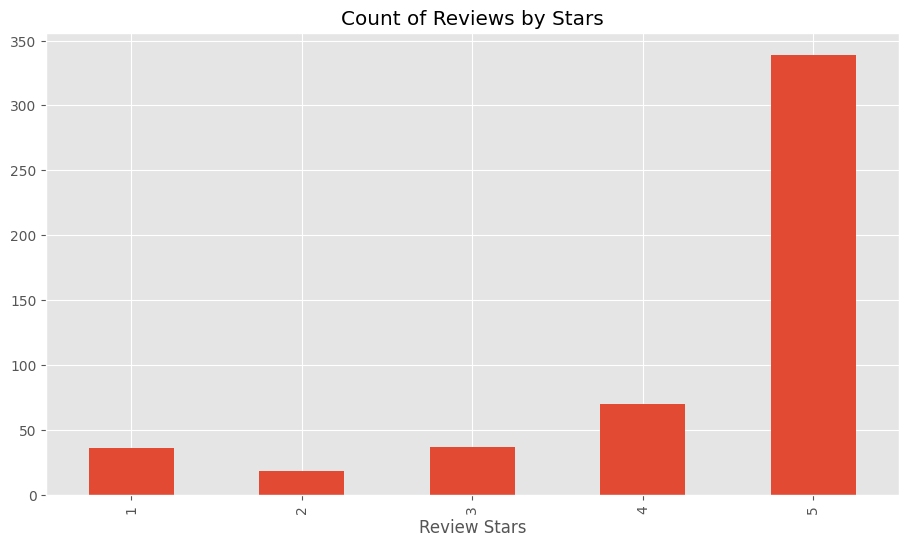

In [14]:
ax=df['Score'].value_counts().sort_index()\
    .plot(kind='bar',title='Count of Reviews by Stars',
                                            figsize=(11,6))
ax.set_xlabel('Review Stars')
plt.show()

Basic NLTK

In [15]:
example=df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [16]:
tokens=nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [17]:
tagged=nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [18]:
#Chunked into sentences
entities=nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


VADER Sentimental Analysis:
- Removes stop words that have no negative and positive eefects on the sentences.
- Helps with sentimental analysis by finding out the +ve and -ve impact of the words.

In [19]:
# Space is provided here to maintain separation between dependencies and logic code. This maintains readability.
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [20]:
# On running sia --0x7b2a318ba140 shows the memory location of the analyzer
sia.polarity_scores("I love reading books!")

# compound is the aggregate og neg,pos and neu, it is between -1 to +1 

{'neg': 0.0, 'neu': 0.308, 'pos': 0.692, 'compound': 0.6696}

In [21]:
sia.polarity_scores('I hate using social media.')

{'neg': 0.552, 'neu': 0.448, 'pos': 0.0, 'compound': -0.5719}

In [22]:
sia.polarity_scores(example)
# The score is more on neg side

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [23]:
# Running the polarity score on the entire data set
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [24]:
vaders=pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df,how='left')

In [26]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.079,0.853,0.068,-0.1027,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**STEP2: Plot VADER Results**

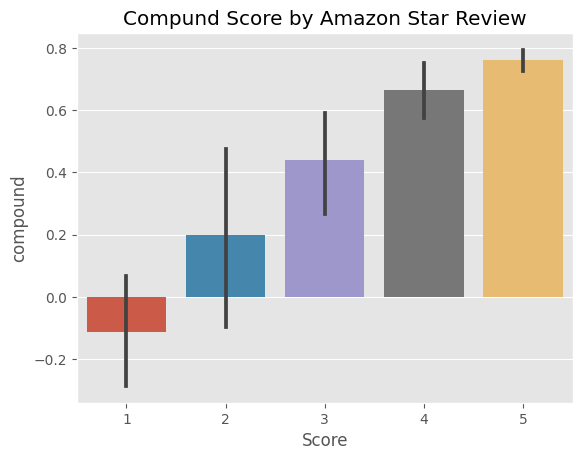

In [27]:
#Compound value will be from -1 to +1
ax=sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

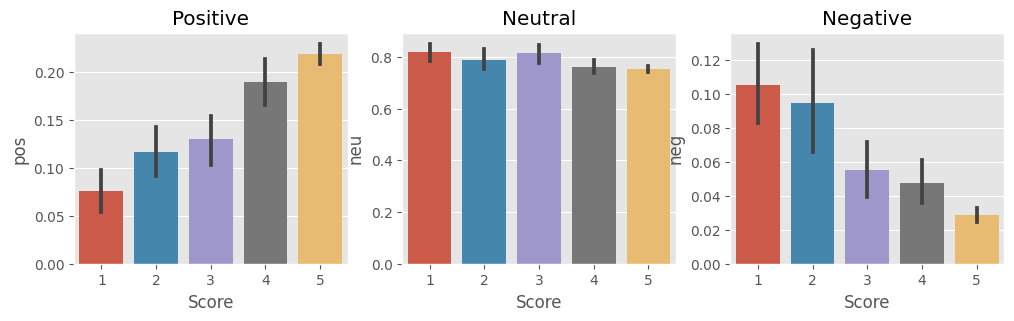

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show

**STEP 3:   Roberta Pretrained Model**

In [29]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
MODEL = "/kaggle/input/twitter-roberta-sentiment-ananlysis/transformers/default/1"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [33]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [39]:
#Run for Roberta Model, this text is the language understood by roberta model.
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.020687463, 'roberta_pos': 0.0029573694}


In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    
    }
    return scores_dict
    

In [59]:
res={}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError: 
        print(f'Broke for id {myid}')
   

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [62]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df,how='left')

In [64]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

## Compare Scores between models

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

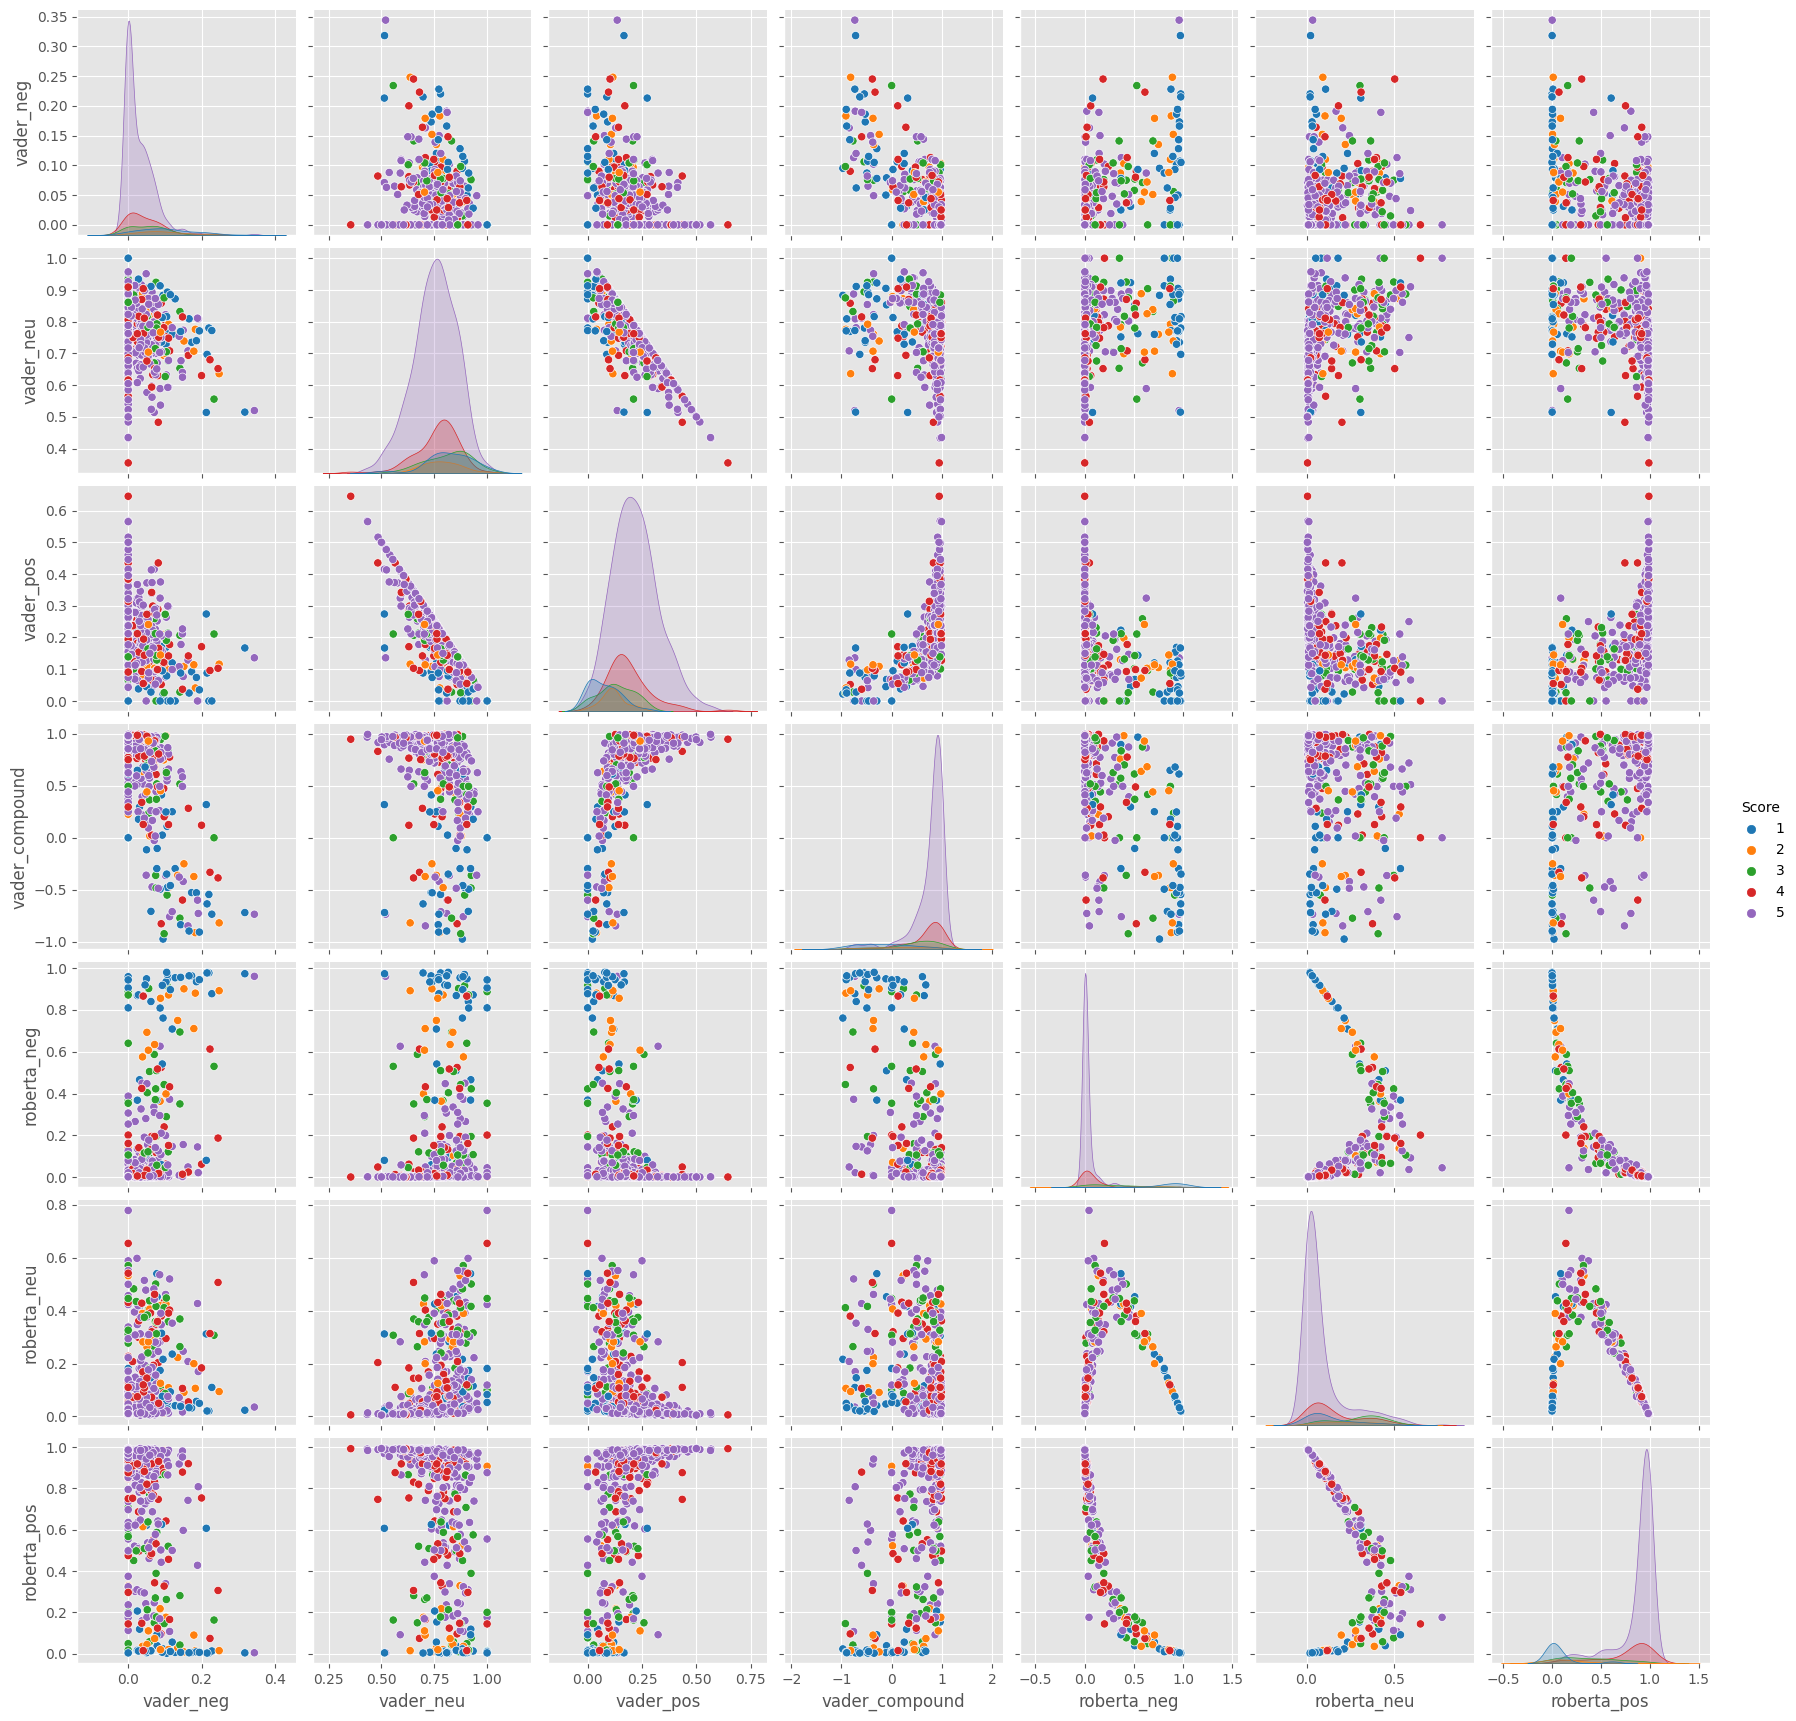

In [67]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Score',
            palette='tab10')
plt.show()

## Step 4: Review Example:
Looking for examples where the model scoring nad review score differ the most

In [71]:
results_df.query('Score == 1')\
    .sort_values('roberta_pos', ascending = False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [72]:
results_df.query('Score == 1')\
    .sort_values('vader_pos', ascending = False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

#Neg of 5 star review

In [73]:
results_df.query('Score == 5')\
    .sort_values('roberta_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [74]:
results_df.query('Score == 5')\
    .sort_values('vader_neg', ascending = False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: The Transformers Pipeline
- Quick and easy way to run sentiment predictions

In [84]:
!ls /kaggle/input/sentiment-analysis/


transformers


In [85]:
!ls /kaggle/input/sentiment-analysis/transformers


default


In [86]:
!ls /kaggle/input/sentiment-analysis/transformers/default


1


In [87]:
!ls /kaggle/input/sentiment-analysis/transformers/default/1

 config.json	 model.safetensors   rust_model.ot	     vocab.txt
 gitattributes	 pytorch_model.bin   tf_model.h5
 map.jpeg	'README (1).md'      tokenizer_config.json


In [90]:
MODEL_PATH = "/kaggle/input/sentiment-analysis/transformers/default/1"


In [91]:
from transformers import pipeline

In [92]:
sent_pipeline = pipeline("sentiment-analysis", model=MODEL_PATH, tokenizer=MODEL_PATH)

Device set to use cpu


In [93]:
text = "I love using DistilBERT for sentiment analysis!"
result = sent_pipeline(text)


In [94]:
print(result)

[{'label': 'POSITIVE', 'score': 0.998206377029419}]


In [95]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [96]:
sent_pipeline('Make sure you like and subscribe.')

[{'label': 'POSITIVE', 'score': 0.998988687992096}]

In [97]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

## The END!!